In [2]:
import sys
import os

arguments = sys.argv

from dotenv import load_dotenv
import numpy as np
load_dotenv()
root = os.environ.get("root_folder")
import numpy as np
 

from pipeline import postprocessing, create_pipeline
from sklearn.model_selection import cross_val_score
# List the candidate models
from candidate_models import candidate_models_df

# Load the data
os.environ["root_folder"] = root
pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test = load_data(root)


 
df_train = pheno_df_train.join(readcounts_df_train)
df_test = pheno_df_test.join(readcounts_df_test)
covariates = df_train.columns

X_train, X_test, y_train, y_test,test_sample_ids = prepare_train_test(df_train, df_test, covariates)

# Loop over the candidate models and optimize them individually
best_score = 0



AttributeError: 'DataFrame' object has no attribute 'ilov'

In [4]:

model = candidate_models_df.iloc[0,0] 
monitor = candidate_models_df.iloc[0,1] 

model = create_pipeline(model) 
model.fit(X_train, y_train, model__monitor=monitor)

# Return predictions
preds_test = model.predict(X_test)

In [43]:
from sksurv.nonparametric import kaplan_meier_estimator

times, KM_survival_prob = kaplan_meier_estimator(y_train["Event"], y_train["Event_time"])

In [44]:
nt = times.shape[0]

predictions = model.predict_survival_function(X_test)
pred_surv_prob = np.row_stack([
    fn(times)
    for fn in predictions
])

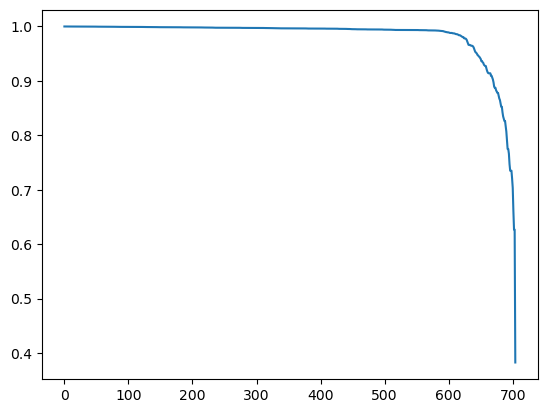

In [45]:
import matplotlib.pyplot as plt

plt.plot(pred_surv_prob[1,:])

In [46]:
id_surv_prob_sorted = np.argsort(pred_surv_prob[:,-2])
pred_surv_prob  = pred_surv_prob[id_surv_prob_sorted,:]

In [47]:
import pandas as pd
Q = 10

In [48]:
categories, bins = pd.cut(
    pred_surv_prob[:,-2],
    np.percentile(pred_surv_prob[:,-2], np.linspace(0, 100, Q + 1)),
    labels=False,
    include_lowest=True,
    retbins=True,
)

When implementing the Cook-Ridker or D’Agostino-Nam translations, the division of groups
and expected values are both based on the survival probability

In [108]:
expevents = np.zeros((Q, nt))
obsevents = np.zeros((Q, nt))
pi = np.zeros((Q, nt))

for i in range(Q):    
    KM_times, KM_survival_prob = kaplan_meier_estimator(y_test[categories == i].Event, y_test[categories == i].Event_time)
    KM_est = ExtentedStepFunction(KM_times, KM_survival_prob)
    KM_i_t = KM_est(times)
    ni = np.sum(categories == i)
    obsevents[i,:] = ni * (1-KM_i_t)
    expevents[i,:] = pred_surv_prob[categories == i,:].sum(axis = 0)
    pi[i,:] = pred_surv_prob[categories == i,:].sum(axis = 0)/ni

In [86]:
chisq_value = np.sum((obsevents - expevents)**2/(expevents*(1-pi)), axis = 0)

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


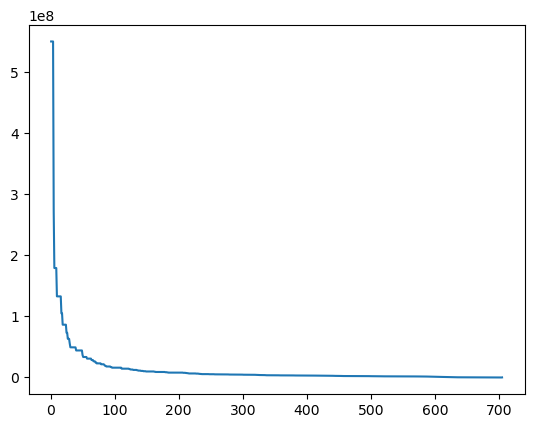

In [91]:
plt.plot(chisq_value)

In [110]:
df = 2 # Cook-Ridler test df = 1 # D'Agostino-Nam test
 

In [111]:
from scipy.stats import chi2
pvalue = 1 - chi2.cdf(chisq_value, Q - df)

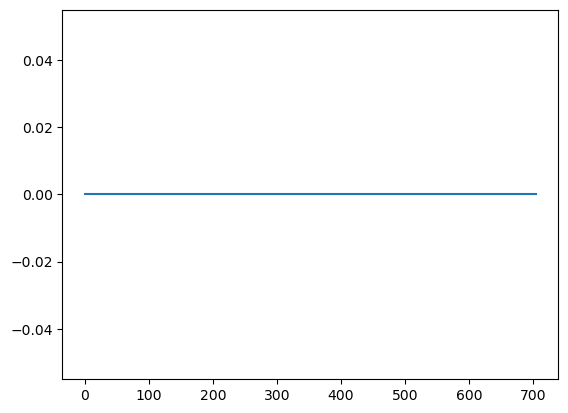

In [112]:
plt.plot(pvalue)